# Julia Unfold test

## Create Julia enviroment

This will install Julia lang in the current enviroment, if not installed yet.

In [1]:
# Import the Julia package manager
from juliacall import Pkg as jlPkg

# Activate the environment in the current folder
jlPkg.activate(".")

# Check the status of the environment/installed packages -> will be empty at the beginning
print(jlPkg.status())

# Install Julia packages
jlPkg.add("Unfold")
jlPkg.add("DataFrames")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/Projects/neuroNoodle`


Status `~/Projects/neuroNoodle/Project.toml`
  [336ed68f] CSV v0.10.14
⌃ [13f3f980] CairoMakie v0.12.5
  [717857b8] DSP v0.7.9
  [a93c6f00] DataFrames v1.6.1
⌃ [ff71e718] MixedModels v4.25.1
⌃ [3eaba693] StatsModels v0.7.3
⌃ [181c99d8] Unfold v0.7.4
  [ec0f67a1] UnfoldDecode v0.1.0 `https://github.com/unfoldtoolbox/UnfoldDecode.jl#main`
⌃ [69a5ce3b] UnfoldMakie v0.5.4
  [ed8ae6d2] UnfoldSim v0.3.2
Info Packages marked with ⌃ have new versions available and may be upgradable.
None


   Resolving package versions...
  No Changes to `~/Projects/neuroNoodle/Project.toml`
  No Changes to `~/Projects/neuroNoodle/Manifest.toml`
Precompiling project...
  ✓ BangBang → BangBangStructArraysExt
  1 dependency successfully precompiled in 2 seconds. 455 already precompiled.
   Resolving package versions...
  No Changes to `~/Projects/neuroNoodle/Project.toml`
  No Changes to `~/Projects/neuroNoodle/Manifest.toml`


Import Julia packages

In [2]:
from juliacall import Main as jl

# The function seval() can be used to evaluate a piece of Julia code given as a string
jl.seval("using DataFrames")
jl.seval("using Unfold")
Unfold = jl.Unfold

Import Python packages

In [3]:
from mne.datasets.limo import load_data
import pandas as pd
import seaborn as sns
import numpy as np
from mne import combine_evoked
from mne.datasets.limo import load_data
from mne.stats import linear_regression
from mne.viz import plot_compare_evokeds, plot_events
import mne

## Load example dataset

In [4]:
# Specify location for the data set
data_path = "."

# Load data for first subject
epochs = load_data(subject=1, path=data_path)

Resample data at 128 Hz to speed up model fitting

In [5]:
epochs.resample(128)

Number of events,1055
Events,Face/A: 524Face/B: 531
Time range,-0.300 – 0.497 s
Baseline,off


### Investigate epochs

In [6]:
epochs.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,131 points
Good channels,"113 EEG, 4 EOG"
Bad channels,"A32, B1, B2, B3, B4, B10, B13, B17, B19, B27, B31, B32, D9, D10, D32"
EOG channels,"EXG1, EXG2, EXG3, EXG4"
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,0.00 Hz
Lowpass,64.00 Hz


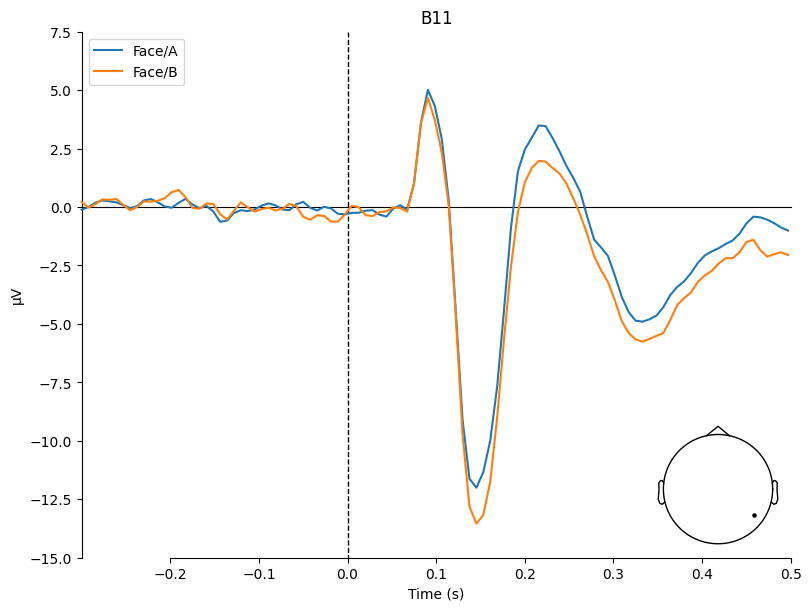

[<Figure size 800x600 with 2 Axes>]

In [7]:
# Create a dictionary containing the evoked responses
conditions = ["Face/A", "Face/B"]
evokeds = {condition: epochs[condition].average() for condition in conditions}

# concentrate analysis an occipital electrodes (e.g. B11)
pick = evokeds["Face/A"].ch_names.index("B11")

# compare evoked responses
plot_compare_evokeds(evokeds, picks=pick, ylim=dict(eeg=(-15, 7.5)))

Create raw

In [8]:
# Extract the data from the epochs and concatenate along the time axis
data = epochs.copy().get_data()
n_epochs, n_channels, n_times = data.shape

# Concatenate the data
# continuous_data = data.reshape(n_channels, n_epochs * n_times)
continuous_data = np.concatenate(data, axis=1) 

# Create a new info object for the RawArray
info = mne.create_info(ch_names=epochs.ch_names, sfreq=epochs.info['sfreq'], ch_types=epochs.get_channel_types())

# Create the continuous RawArray object
continuous_raw = mne.io.RawArray(continuous_data, info)

# Extract the event information
events = epochs.events
event_id = epochs.event_id

# Calculate the latencies in the continuous signal
# Latencies are in samples, so they need to be adjusted based on epoch duration
latencies = events[:, 0] * n_times + int(0.3*128)

# Create the DataFrame
event_codes = events[:, 2]
df = pd.DataFrame({'latency': latencies, 'EventCode': event_codes})
df['face'] = df['EventCode'].map(lambda x: 'eventA' if x == 0 else 'eventB')

events_new = events.copy()
events_new[:,0] = df['latency'].to_numpy()

Creating RawArray with float64 data, n_channels=132, n_times=108665
    Range : 0 ... 108664 =      0.000 ...   848.938 secs
Ready.


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_10510/2161287474.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.copy().get_data()


In [9]:
events_new

array([[    38,      0,      0],
       [   141,      0,      0],
       [   244,      0,      0],
       ...,
       [108394,      0,      1],
       [108497,      0,      1],
       [108600,      0,      1]])

In [10]:
# create epochs
tmin=-0.3
tmax=0.5

epochs_2 = mne.Epochs(
  raw=continuous_raw,
  events=events_new,
  event_id={'Face/A': 0, 'Face/B': 1},
  tmin=tmin,
  tmax=tmax,
  baseline=None,
  preload=True,
)

Not setting metadata
1055 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1055 events and 103 original time points ...
0 bad epochs dropped


In [11]:
epochs_2

Number of events,1055
Events,Face/A: 524Face/B: 531
Time range,-0.297 – 0.500 s
Baseline,off


In [12]:
epochs_2.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"128 EEG, 4 EOG"
Bad channels,None
EOG channels,"EXG1, EXG2, EXG3, EXG4"
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,0.00 Hz
Lowpass,64.00 Hz


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_10510/3360925110.py:9: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  plot_compare_evokeds(evokeds, picks=pick, ylim=dict(eeg=(-15, 7.5)))


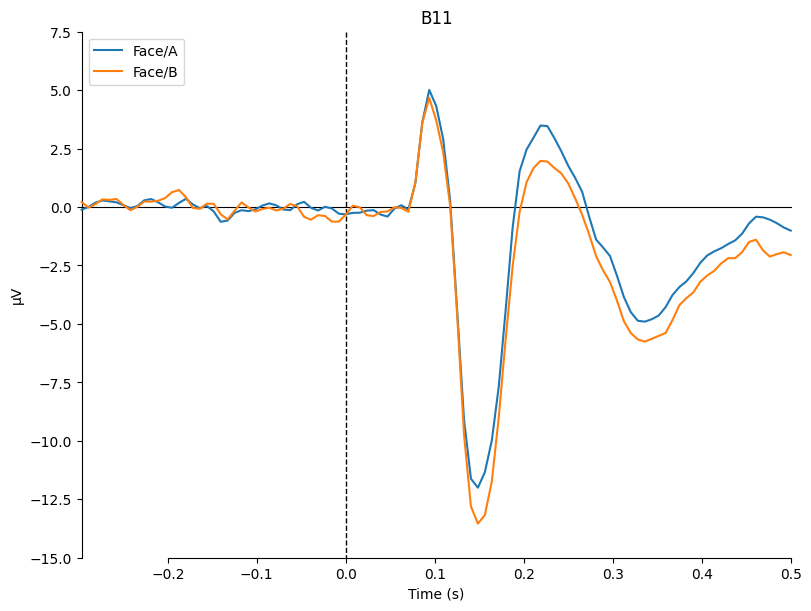

[<Figure size 800x600 with 1 Axes>]

In [13]:
# Create a dictionary containing the evoked responses
conditions = ["Face/A", "Face/B"]
evokeds = {condition: epochs_2[condition].average() for condition in conditions}

# concentrate analysis an occipital electrodes (e.g. B11)
pick = evokeds["Face/A"].ch_names.index("B11")

# compare evoked responses
plot_compare_evokeds(evokeds, picks=pick, ylim=dict(eeg=(-15, 7.5)))

In [14]:
data_original = continuous_raw.get_data(picks='eeg')
data_original.shape

(128, 108665)

## Fit Unfold model

In [23]:
events_df

Row,latency,face
,Int64,String
1,38,eventA
2,141,eventA
3,244,eventA
4,347,eventA
5,450,eventA
6,553,eventA
7,656,eventA
8,759,eventA
9,862,eventA


In [19]:
# Specify model formula
bf1 = jl.seval("bf1 = firbasis(τ = (-0.3, 0.5), sfreq = 128)")
bf2 = jl.seval("bf2 = firbasis(τ = (-0.3, 0.5), sfreq = 128)")

formula = jl.seval("f = @formula 0 ~ 1 ")
bfDict = jl.seval("[ \"eventA\" => (f, bf1), \"eventB\" => (f, bf2) ]")

# Convert the Python columns to Julia arrays
face_column = jl.seval("Vector{String}")(df['face'].tolist())
latency_column = jl.seval("Vector{Int64}")(df['latency'].tolist())

# Create the Julia DataFrame
events_df = jl.DataFrame(face=face_column, latency=latency_column)

# Fit Unfold model
m = Unfold.fit(
    Unfold.UnfoldModel,
    bfDict,
    events_df,
    data_original,
    # solver = jl.seval("(x, y) -> Unfold.solver_default(x, y; stderror = true)"),
    eventcolumn = "face",
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [20]:
events_df

Row,latency,face
,Int64,String
1,38,eventA
2,141,eventA
3,244,eventA
4,347,eventA
5,450,eventA
6,553,eventA
7,656,eventA
8,759,eventA
9,862,eventA


In [24]:
# Extract coefficient table
results_jl = Unfold.coeftable(m)

# Transfer results back to Python
results_py_df = pd.DataFrame({
    'channel': results_jl.channel,
    'coefname': results_jl.coefname,
    'estimate': results_jl.estimate,
    'eventname': results_jl.eventname,
    'group': results_jl.group,
    'stderror': results_jl.stderror,
    'time': results_jl.time
})

results_py_df.head()

,channel,coefname,estimate,eventname,group,stderror,time
0,1,(Intercept),1.566518e-06,eventA,None,None,-0.296875
1,2,(Intercept),1.163320e-06,eventA,None,None,-0.296875
2,3,(Intercept),1.180394e-06,eventA,None,None,-0.296875
3,4,(Intercept),9.682347e-07,eventA,None,None,-0.296875
4,5,(Intercept),1.144127e-07,eventA,None,None,-0.296875


In [25]:
results_py_df

,channel,coefname,estimate,eventname,group,stderror,time
0,1,(Intercept),1.566518e-06,eventA,None,None,-0.296875
1,2,(Intercept),1.163320e-06,eventA,None,None,-0.296875
2,3,(Intercept),1.180394e-06,eventA,None,None,-0.296875
3,4,(Intercept),9.682347e-07,eventA,None,None,-0.296875
4,5,(Intercept),1.144127e-07,eventA,None,None,-0.296875
...,...,...,...,...,...,...,...
26363,124,(Intercept),2.744125e-07,eventB,None,None,0.500000
26364,125,(Intercept),-4.008093e-07,eventB,None,None,0.500000
26365,126,(Intercept),1.307347e-07,eventB,None,None,0.500000
26366,127,(Intercept),-1.950116e-07,eventB,None,None,0.500000


## Visualize the results

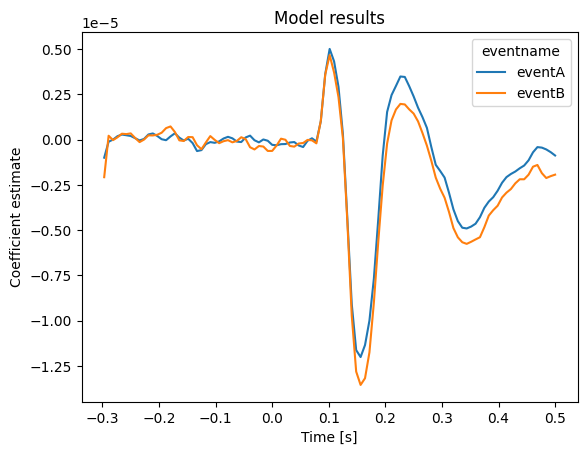

In [26]:
# Extract the coefficients for one channel
results_ch = results_py_df[results_py_df.channel == 43]

# Plot the coefficient estimates over time
ax = sns.lineplot(x = results_ch.time,y=results_ch.estimate,hue=results_ch.eventname)
ax.set(xlabel='Time [s]', ylabel='Coefficient estimate', title='Model results');